In [2]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import poppy

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
from adefc_vortex import dm
from adefc_vortex import props
from adefc_vortex import aefc_1dm as aefc
import adefc_vortex.pwp as pwp
import adefc_vortex.scoob_model as scoobm
import adefc_vortex.scoob_interface as scoobi

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient
client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()

wavelength_c = 633e-9
npix = 1000


In [42]:
scoobi.home_block(client0)

In [43]:
scoobi.move_block_out(client0)

In [48]:
reload(scoobi)
xc, yc = (4600, 3400)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [49]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp05')
I.npsf = 150

# Do the normalization

In [54]:
scoobi.move_psf(50, 0, client0)

In [55]:
reload(scoobi)
I.set_zwo_exp_time(0.0002, client0)

Set the ZWO exposure time to 2.00e-04s


In [56]:
reload(scoobi)
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [57]:
reload(scoobi)
I.set_fib_atten(35, client)

Set the fiber attenuation to 35.0


INFO:utils:Got semaphore index 1.


38023.72


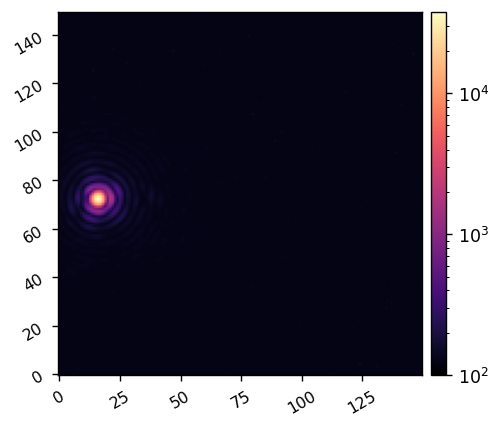

In [58]:
I.NSCICAM = 200
ref_psf = I.snap()
print(xp.max(ref_psf))
imshow1(ref_psf, lognorm=True, vmin=1e2)

In [59]:
I.ref_psf_params = {
    'ref_psf':copy.copy(ref_psf),
    'Imax': copy.copy(xp.max(ref_psf)),
    'texp': copy.copy(I.texp), 
    'atten': copy.copy(I.atten),
    'gain': copy.copy(I.gain),
}
utils.save_pickle(f'data/{today}_ref_psf_params.pkl', I.ref_psf_params)

# I.ref_psf_params = utils.load_pickle(f'data/{today}_ref_psf_params.pkl')

Saved data to:  data/20250115_ref_psf_params.pkl


In [100]:
scoobi.move_psf(-1, 0, client0)


In [102]:
scoobi.move_psf(0, -1, client0)

In [68]:
I.set_fib_atten(25, client)

Set the fiber attenuation to 25.0


In [69]:
I.set_zwo_exp_time(0.1, client0)

Set the ZWO exposure time to 1.00e-01s


In [34]:
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [103]:
reload(scoobi)
scoobi.move_block_in(client0)

Saved data to:  data/20250115_camsci_dark_frame.pkl


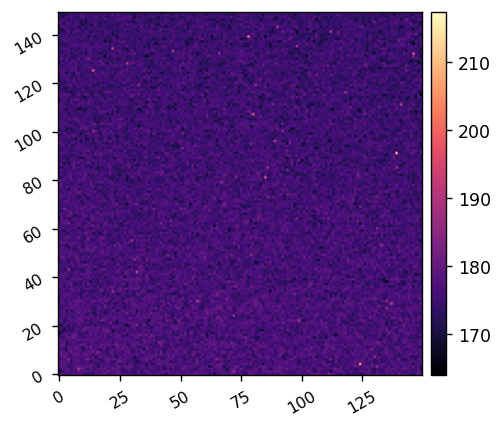

In [104]:
I.NSCICAM = 200
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
utils.save_pickle(f'data/{today}_camsci_dark_frame.pkl', dark_frame)
I.df = copy.copy(dark_frame)
imshow1(dark_frame)

# dark_frame = utils.load_pickle(f'data/{today}_camsci_dark_frame.pkl')
# I.df = copy.copy(dark_frame)
# imshow1(dark_frame)

In [105]:
reload(scoobi)
scoobi.move_block_out(client0)

In [108]:
I.set_fib_atten(27, client)

Set the fiber attenuation to 27.0


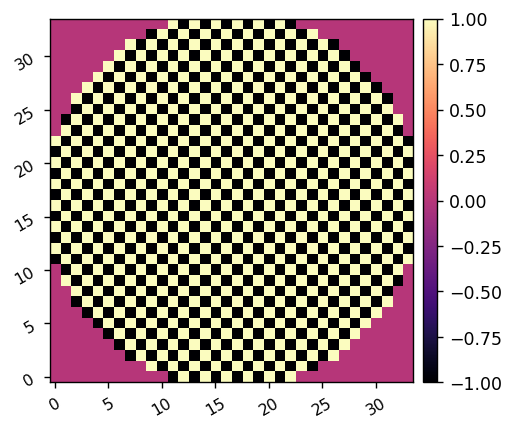

In [106]:
reload(scoobi.utils)
waffle_command = utils.make_fourier_command(x_cpa=17, y_cpa=17) * xp.array(I.dm_mask)
imshow1(waffle_command)

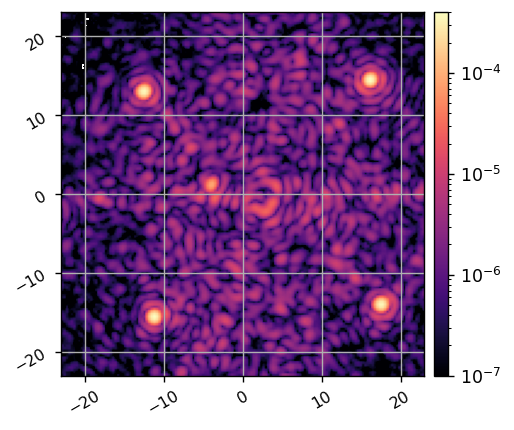

In [109]:
I.set_dm(15e-9 * waffle_command)
I.x_shift = 0
I.y_shift = 0

# original_texp = I.texp
# I.set_zwo_exp_time(0.005, client0)

I.NSCICAM = 10
I.subtract_dark = True
I.return_ni = True
waffle_im = I.snap()
imshow1(waffle_im, lognorm=True, vmin=1e-7, pxscl=I.psf_pixelscale_lamDc, grid=True)

# I.set_zwo_exp_time(original_texp, client0)


Centroids:
 [[ 37.97815951  23.96366597]
 [ 33.77305726 116.824181  ]
 [126.97759739 121.6143244 ]
 [131.39477737  29.02193978]
 [ 37.97815951  23.96366597]]


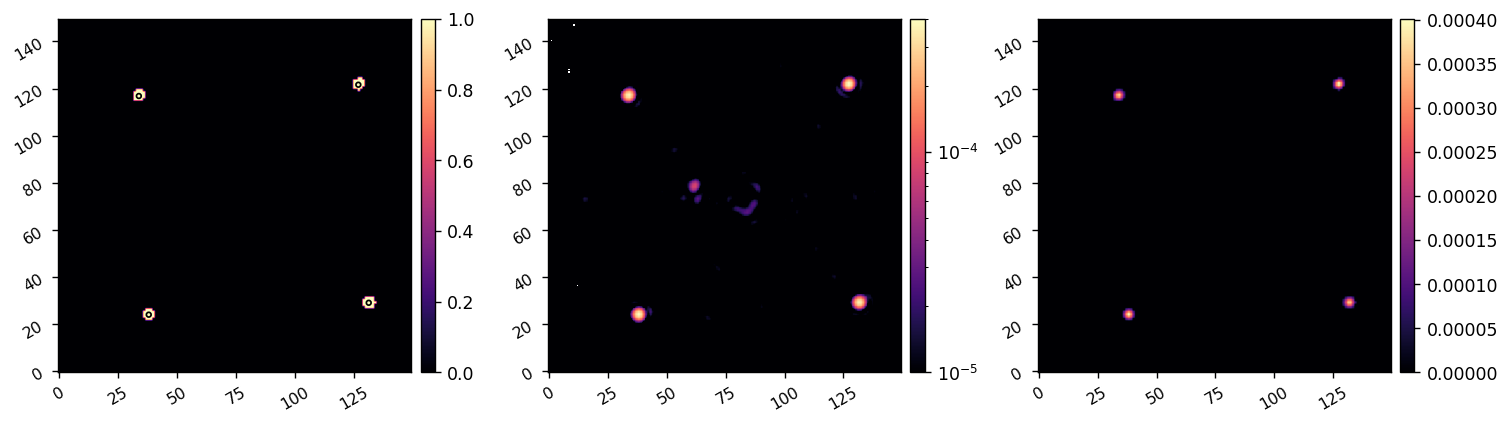

Angle:  87.1586160584583
Measured center in X:  82.592791721081
Measured center in Y:  72.91507863855374
Required shift in X:  -8.0
Required shift in Y:  2.0


In [110]:
reload(utils)

xshift, yshift, angle = utils.measure_center_and_angle(
    waffle_im, 
    I.psf_pixelscale_lamDc, 
    im_thresh=7e-5, 
    r_thresh=16,
)

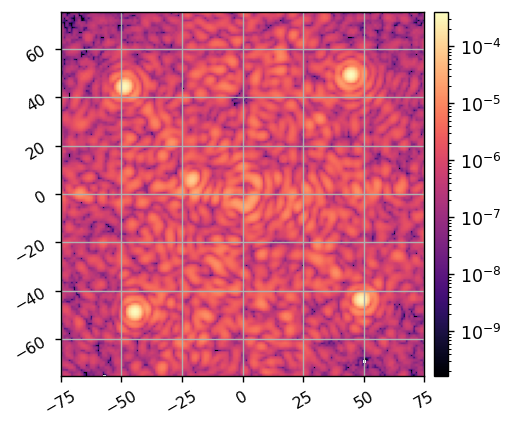

In [111]:
I.NSCICAM = 10
I.npsf = 150
I.x_shift = xshift
I.y_shift = yshift

I.subtract_dark = True
I.return_ni = True

waffle_im = I.snap()
imshow1(waffle_im, lognorm=True, pxscl=1, grid=True)

In [133]:
I.set_fib_atten(15, client)

Set the fiber attenuation to 15.0


1.8562976292583979e-06


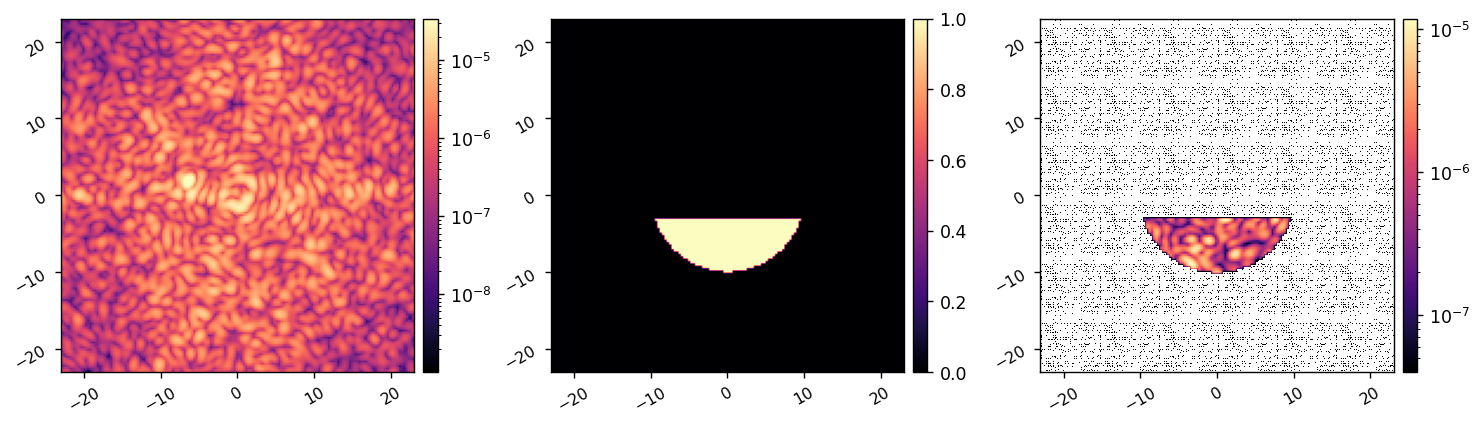

In [134]:
iwa = 3
owa = 10
rotation = 90
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, iwa, owa, edge=iwa, rotation=rotation)

I.zero_dm()
I.NSCICAM = 20
I.subtract_dark = True
I.return_ni = True

ref_coro_im = I.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=I.psf_pixelscale_lamDc)

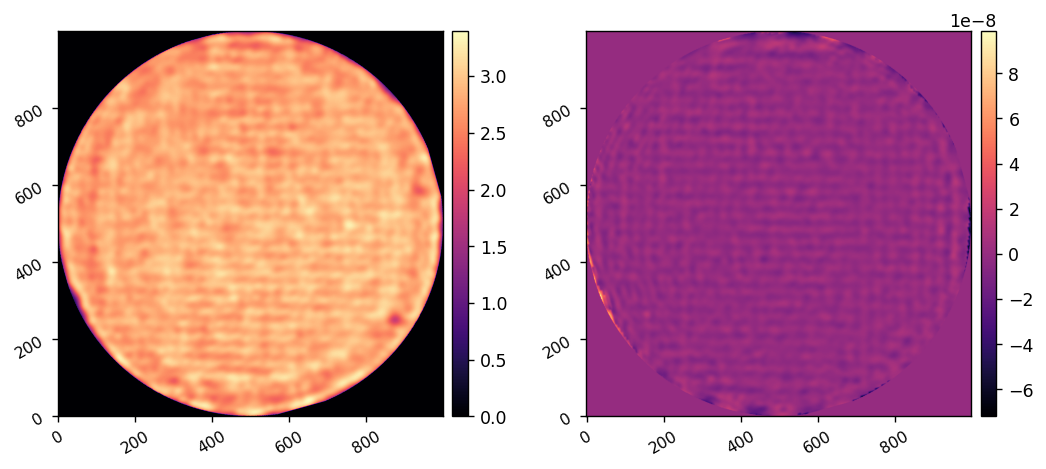

In [114]:
pr_fit = utils.load_pickle(f'data/20250114_fdpr2_ref_processed.pkl')

wfe_amp = pr_fit['amp']
wfe_opd = pr_fit['opd']
imshow2(wfe_amp, wfe_opd)

In [151]:
16/34 * 2 * 10.2

9.6

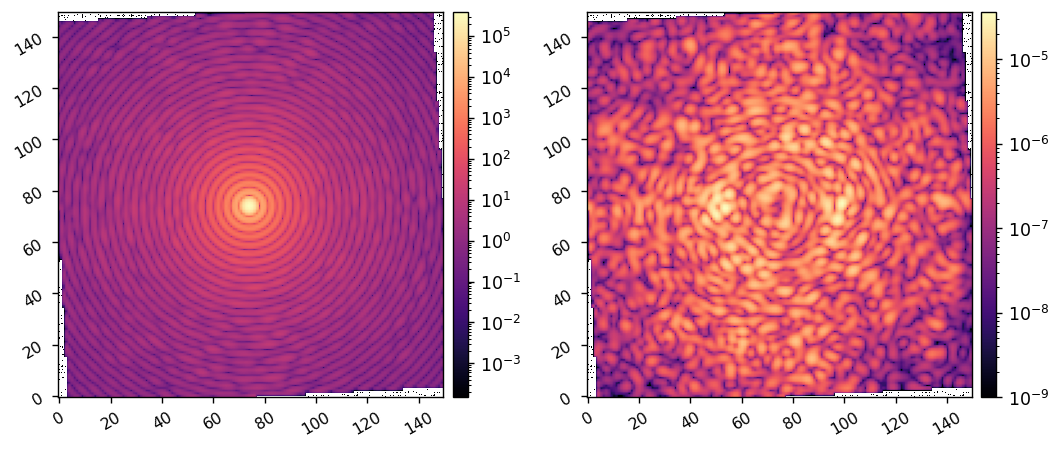

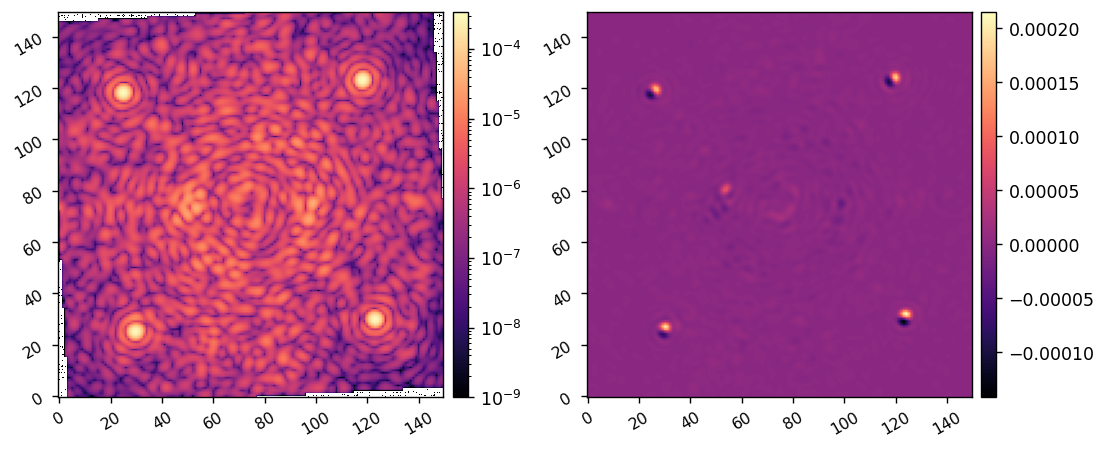

In [155]:
reload(scoobm)
M = scoobm.MODEL(
    dm_beam_diam=9.4*u.mm, 
    lyot_pupil_diam=9.4*u.mm,
    # dm_shift=np.array([0.1,0.0])*u.mm,
    # lyot_shift=np.array([0,0.35])*u.mm,
)
M.AMP = wfe_amp
M.OPD = wfe_opd

M.reverse_lyot = 1
M.flip_lyot = 1
M.det_rotation = 177.

M.setattr('use_vortex', False)
m_ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(m_ref_psf))

M.setattr('use_vortex', True)
m_coro_im = M.snap()

imshow2(
    m_ref_psf, m_coro_im, 
    lognorm=1,
    vmin2=1e-9,
)

M.set_dm(7.5e-9 * waffle_command)
m_waffle_im = M.snap()
M.zero_dm()

imshow2(
    m_waffle_im, waffle_im-m_waffle_im, 
    lognorm1=True, 
    vmin1=1e-9,
)
# fpwf = M.forward(np.zeros(M.Nacts), use_vortex=True, plot=True)


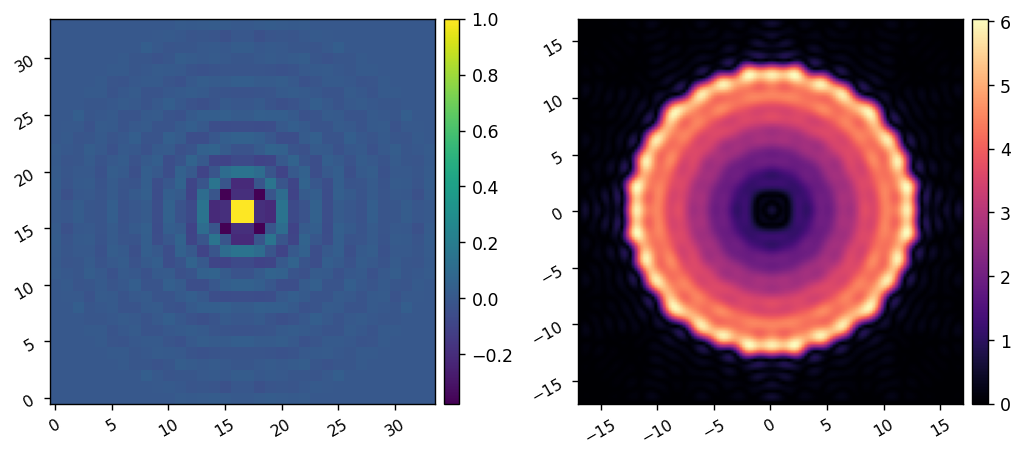

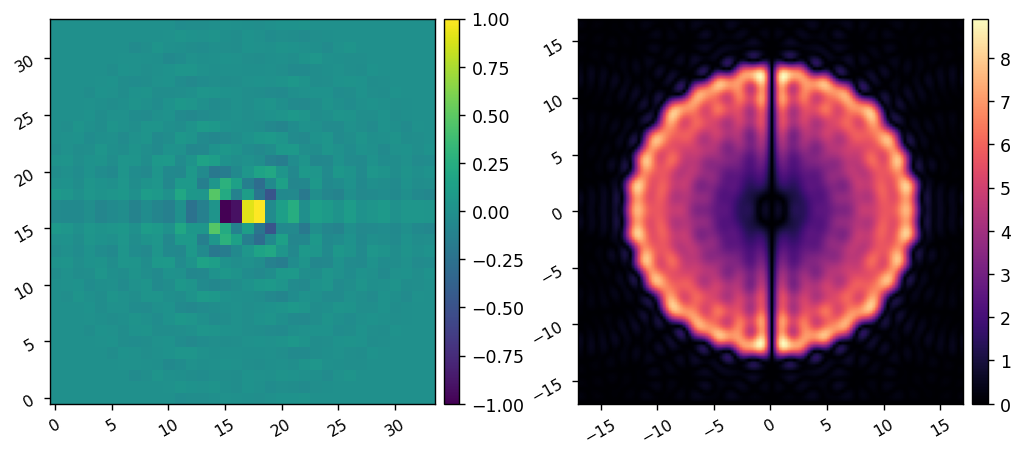

In [156]:
reload(utils)
fourier_probes = utils.create_fourier_probes(
    xp.array(I.dm_mask), 
    I.npsf, 
    I.psf_pixelscale_lamDc, 
    iwa-0.5, owa+2, 
    # edge=iwa-0.5,
    fourier_sampling=0.75, 
    # rotation=90,
    nprobes=2,
    plot=True,
    use_weighting=True
)
fourier_probes[0] = xp.rot90(fourier_probes[0])
fourier_probes[1] = xp.rot90(fourier_probes[1])

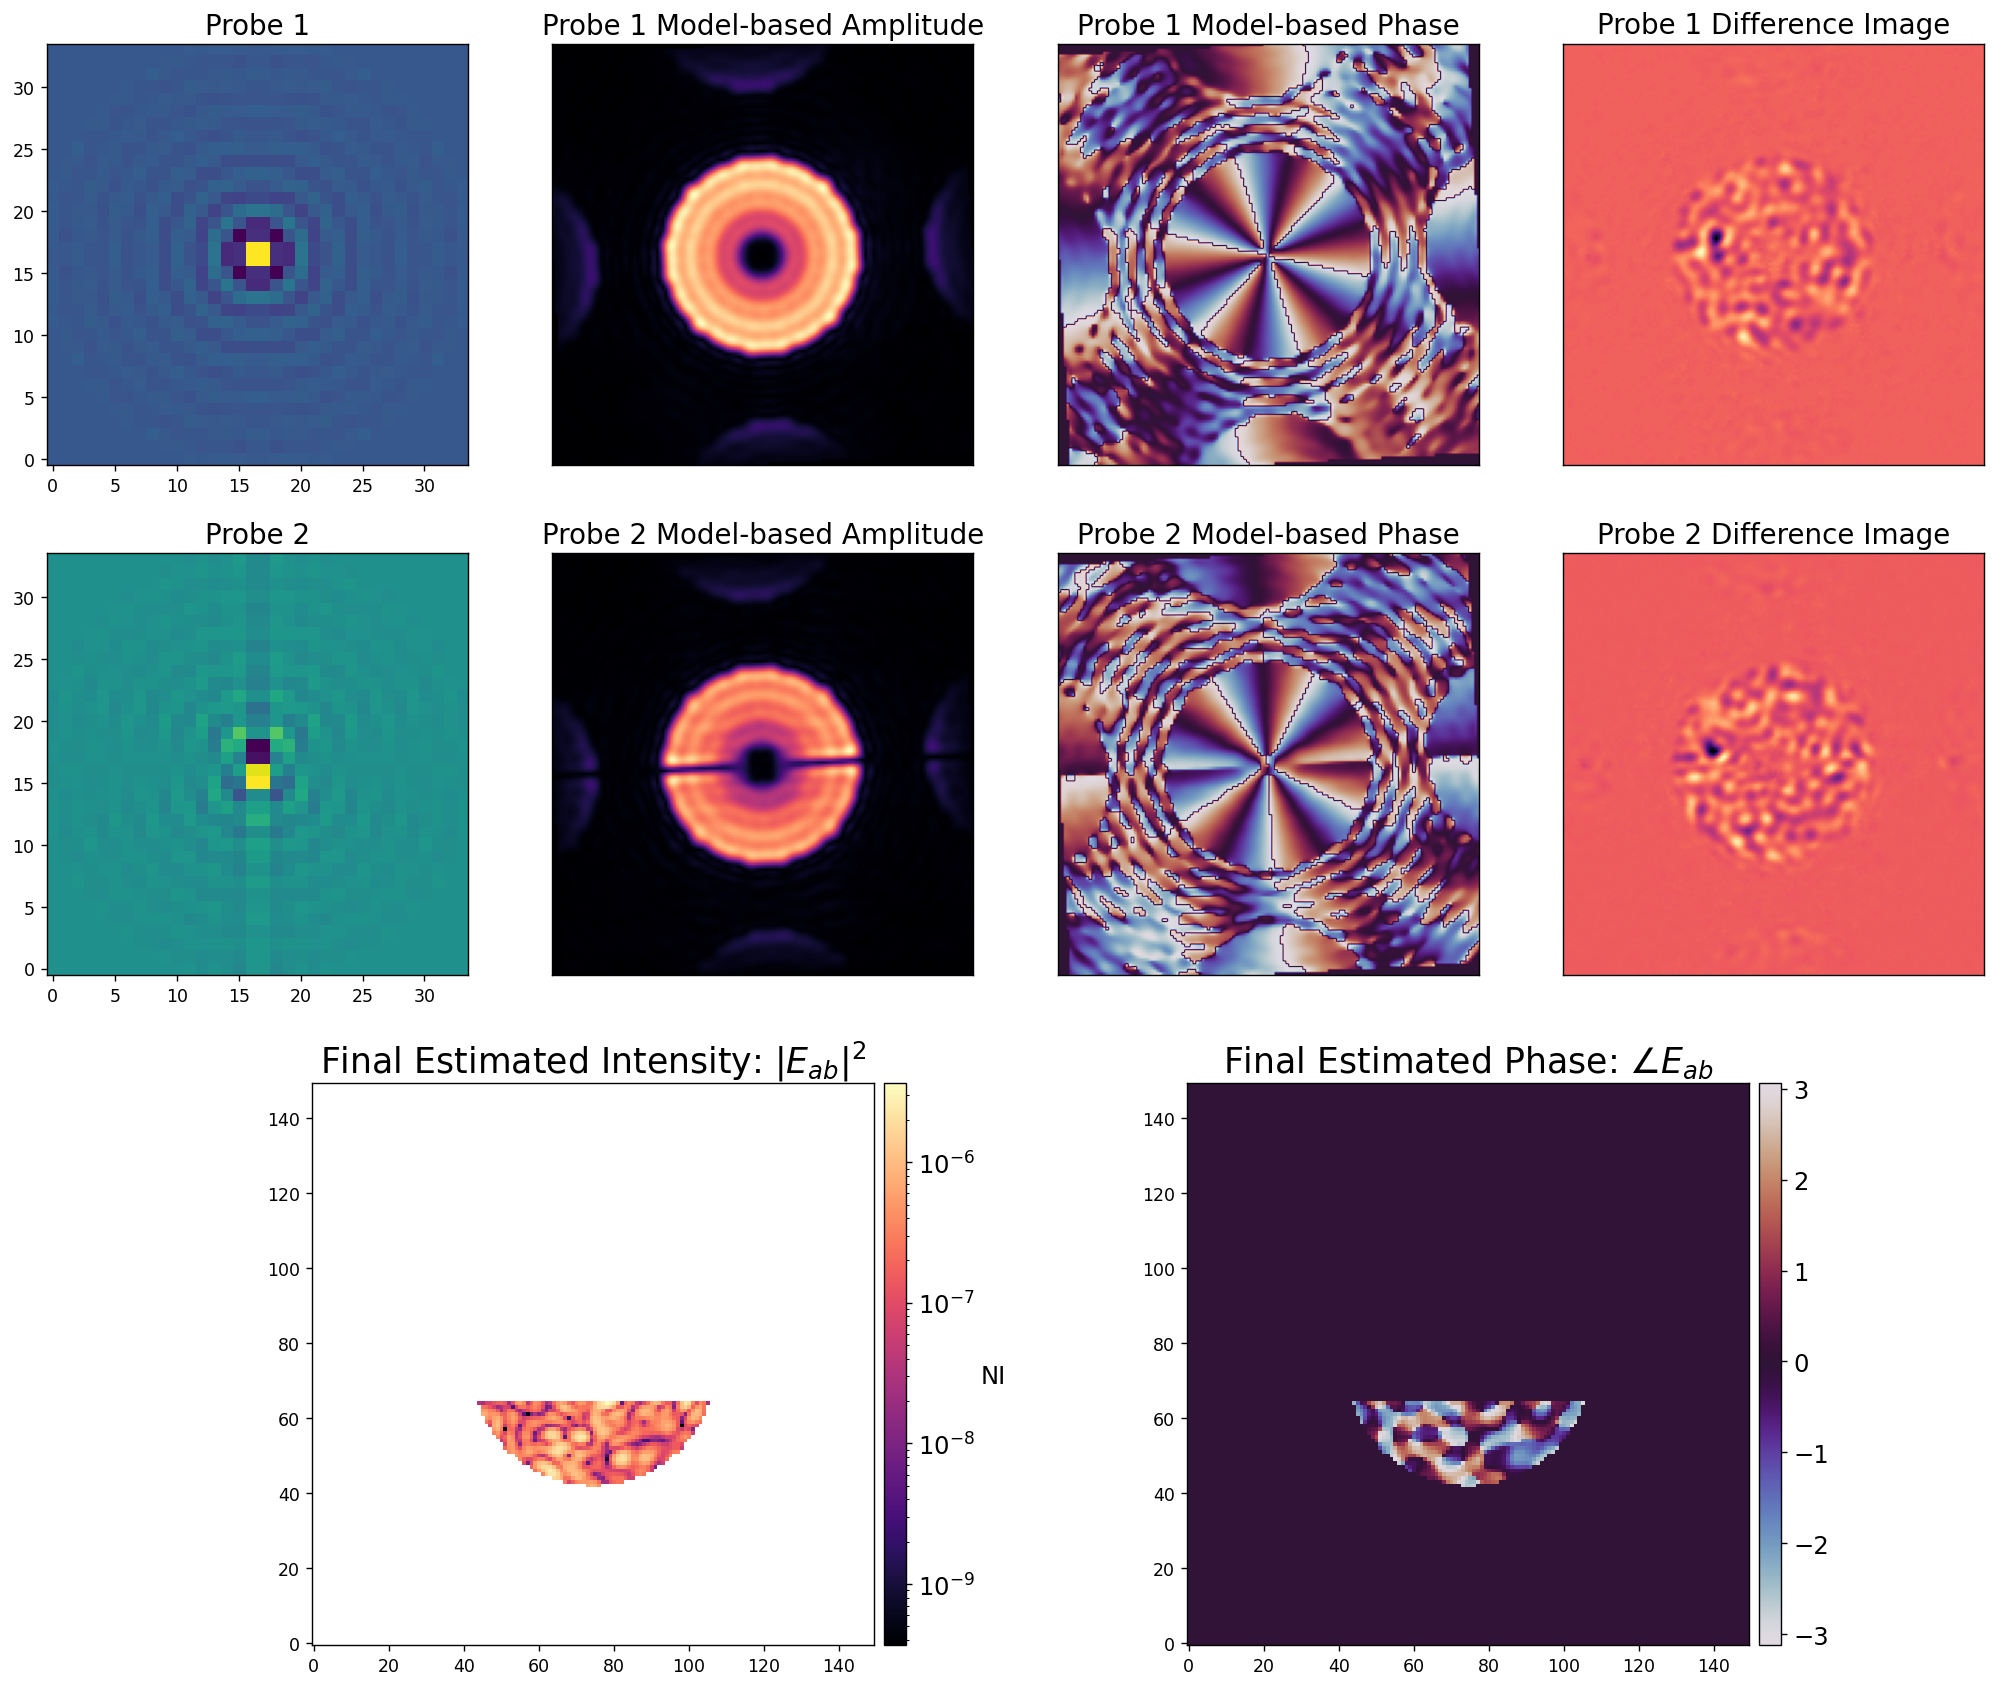

In [157]:
reload(pwp)

acts = xp.zeros(M.Nacts)

I.set_dm(scoobm.acts_to_command(acts, M.dm_mask))
E_pwp = pwp.run(
    I, 
    M, 
    control_mask, 
    fourier_probes, 
    2.5e-9, 
    I.wavelength_c, 
    reg_cond=1e-2, 
    Ndms=1,
    plot=True,
)
I_pwp = xp.abs(E_pwp)**2
P_pwp = xp.angle(E_pwp)

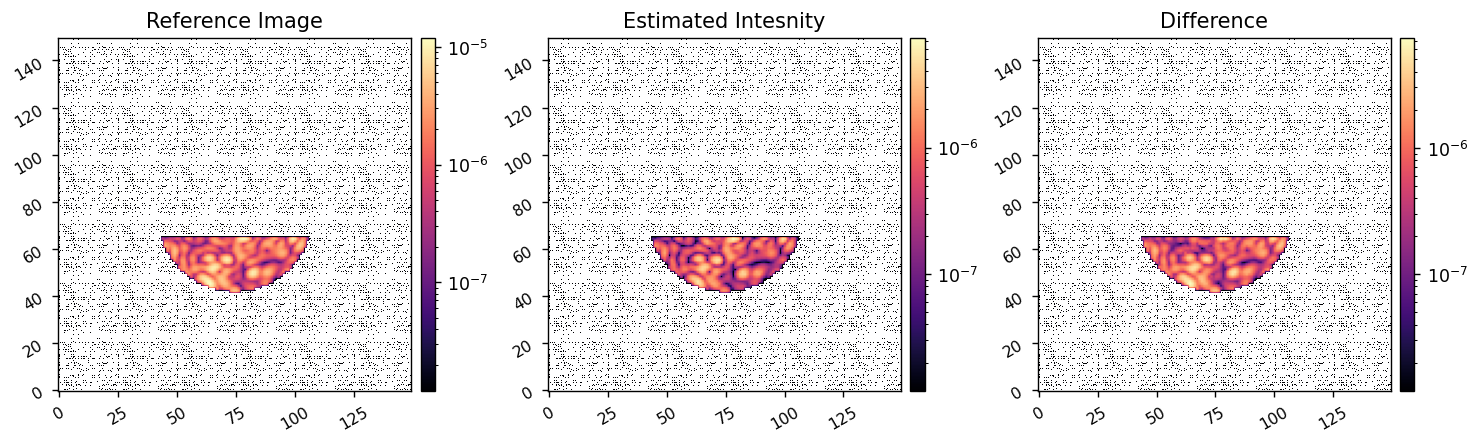

In [158]:
I_diff = ref_coro_im*control_mask - 2*I_pwp
vmin = xp.max(ref_coro_im*control_mask)/1e3
imshow3(ref_coro_im*control_mask, 2*I_pwp, xp.abs(I_diff), 
        'Reference Image', 'Estimated Intesnity', 'Difference',
        lognorm1=True, lognorm2=True, vmin1=vmin, vmin2=vmin, 
        lognorm3=True, vmin3=vmin,
        )

In [159]:
I.zero_dm()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'commands':[],
    'del_commands':[],
    'reg_conds':[],
    'bfgs_tols':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

In [181]:
I.set_fib_atten(0, client)

Set the fiber attenuation to 0.0


Running iteration 48
Running PWP ...


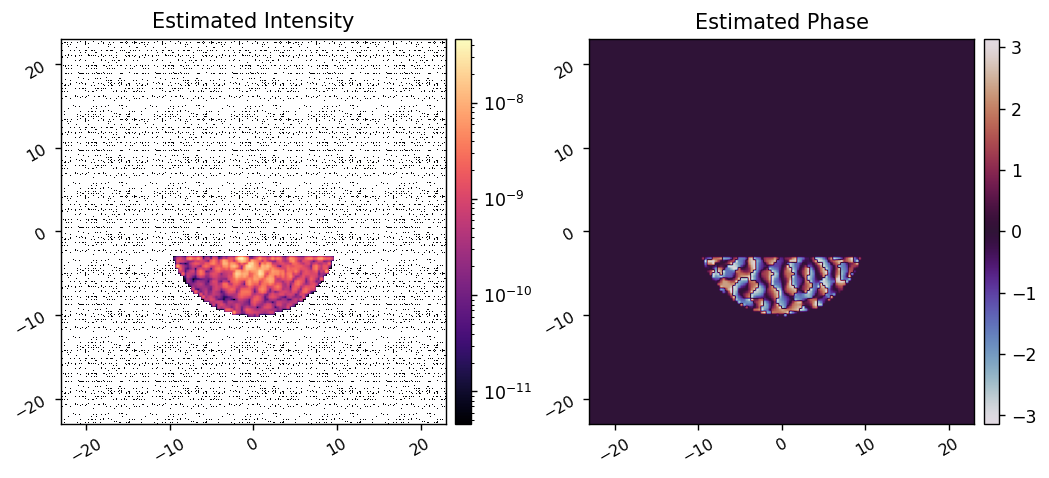

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  2.72684D+08


 This problem is unconstrained.



At iterate    1    f=  8.19971D-01    |proj g|=  7.30368D+07

At iterate    2    f=  7.81997D-01    |proj g|=  5.29456D+07

At iterate    3    f=  7.58996D-01    |proj g|=  4.18866D+07

At iterate    4    f=  7.42506D-01    |proj g|=  3.72543D+07

At iterate    5    f=  7.29396D-01    |proj g|=  2.92442D+07

At iterate    6    f=  7.21214D-01    |proj g|=  2.32669D+07

At iterate    7    f=  7.15587D-01    |proj g|=  2.53399D+07

At iterate    8    f=  7.10056D-01    |proj g|=  2.42419D+07

At iterate    9    f=  7.05303D-01    |proj g|=  3.43182D+07

At iterate   10    f=  7.00557D-01    |proj g|=  2.50705D+07

At iterate   11    f=  6.96638D-01    |proj g|=  1.83671D+07

At iterate   12    f=  6.94259D-01    |proj g|=  2.35675D+07

At iterate   13    f=  6.93930D-01    |proj g|=  2.26446D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

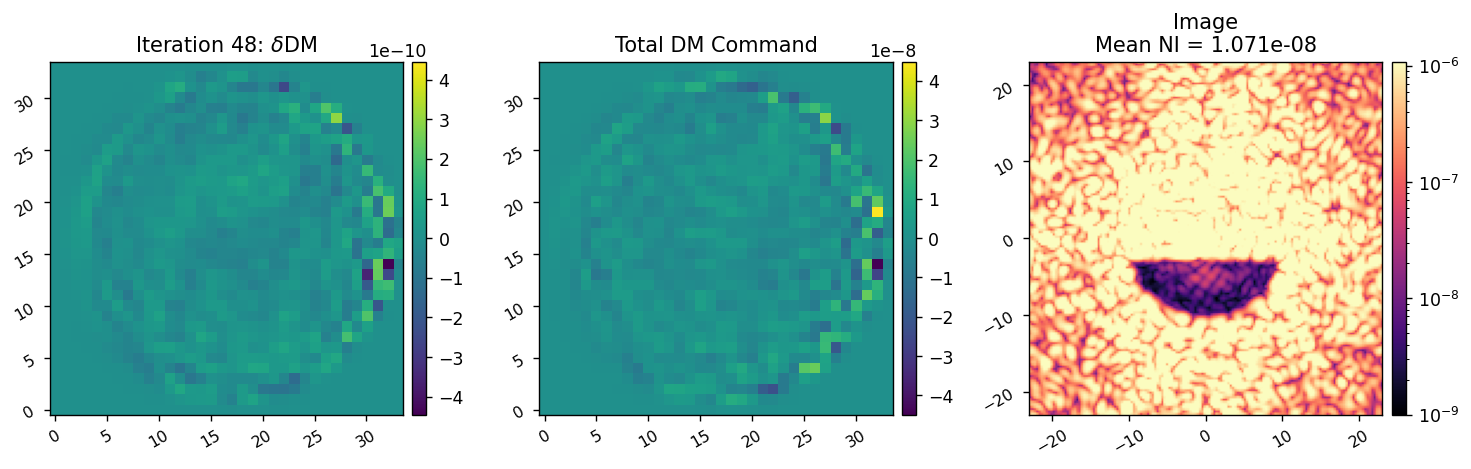

Running iteration 49
Running PWP ...


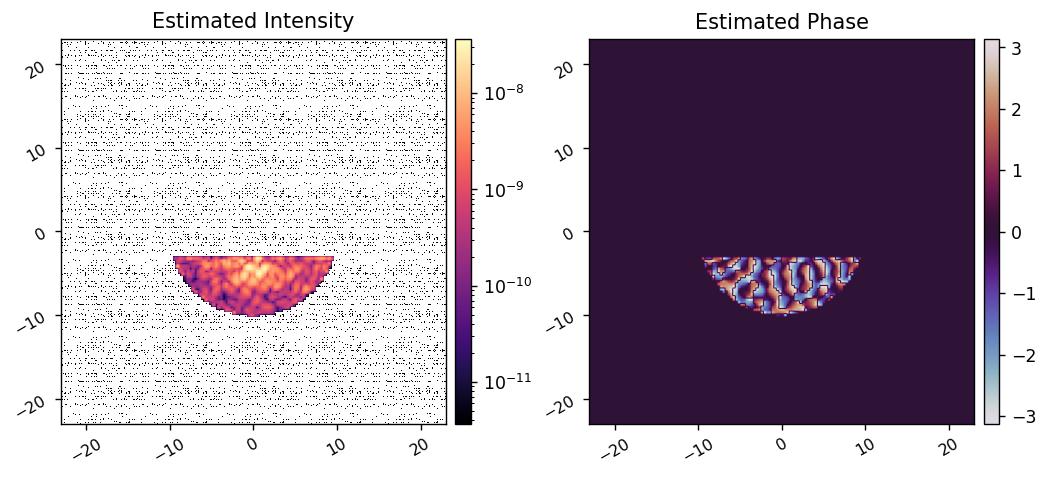

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  2.48401D+08


 This problem is unconstrained.



At iterate    1    f=  8.36871D-01    |proj g|=  7.01299D+07

At iterate    2    f=  8.03240D-01    |proj g|=  4.63815D+07

At iterate    3    f=  7.84281D-01    |proj g|=  3.60444D+07

At iterate    4    f=  7.70312D-01    |proj g|=  3.23144D+07

At iterate    5    f=  7.57350D-01    |proj g|=  3.01178D+07

At iterate    6    f=  7.49492D-01    |proj g|=  2.71616D+07

At iterate    7    f=  7.43762D-01    |proj g|=  2.41659D+07

At iterate    8    f=  7.37674D-01    |proj g|=  2.48425D+07

At iterate    9    f=  7.33452D-01    |proj g|=  3.87822D+07

At iterate   10    f=  7.28392D-01    |proj g|=  2.39445D+07

At iterate   11    f=  7.25066D-01    |proj g|=  1.76707D+07

At iterate   12    f=  7.22614D-01    |proj g|=  2.31028D+07

At iterate   13    f=  7.20959D-01    |proj g|=  1.90632D+07

At iterate   14    f=  7.18951D-01    |proj g|=  1.87093D+07

At iterate   15    f=  7.17079D-01    |proj g|=  2.13175D+07

At iterate   16    f=  7.15813D-01    |proj g|=  2.22804D+07

At iter

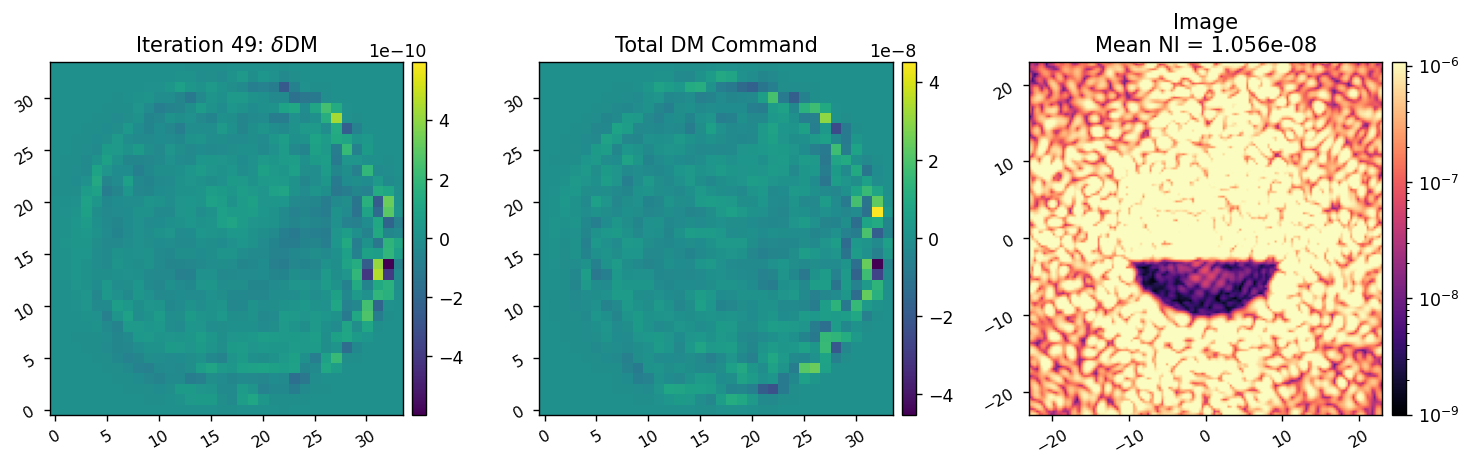

Running iteration 50
Running PWP ...


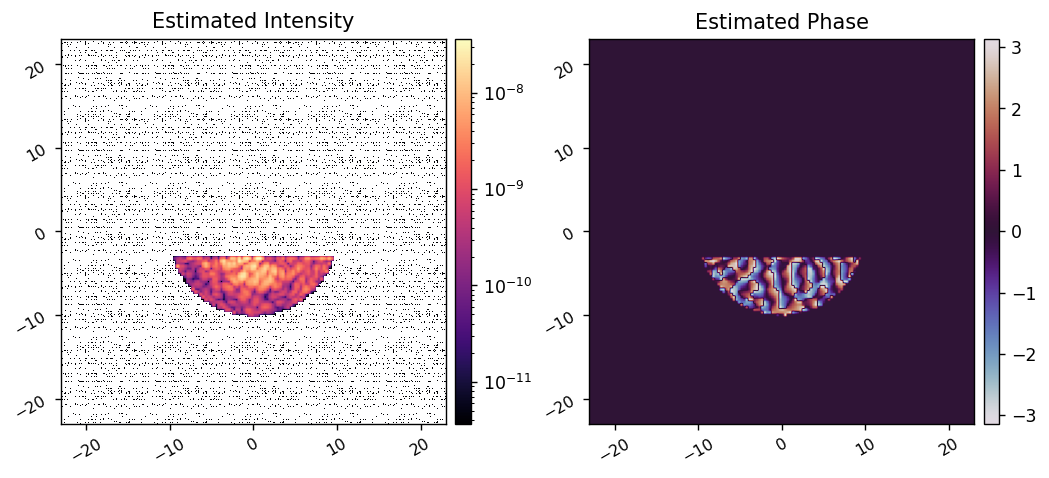

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.83010D+08


 This problem is unconstrained.



At iterate    1    f=  8.53732D-01    |proj g|=  6.32043D+07

At iterate    2    f=  8.19077D-01    |proj g|=  3.93854D+07

At iterate    3    f=  7.97386D-01    |proj g|=  3.28454D+07

At iterate    4    f=  7.82207D-01    |proj g|=  3.05811D+07

At iterate    5    f=  7.70661D-01    |proj g|=  2.59809D+07

At iterate    6    f=  7.64220D-01    |proj g|=  2.21374D+07

At iterate    7    f=  7.59523D-01    |proj g|=  2.10793D+07

At iterate    8    f=  7.52430D-01    |proj g|=  2.50933D+07

At iterate    9    f=  7.49576D-01    |proj g|=  5.04926D+07

At iterate   10    f=  7.41978D-01    |proj g|=  2.62417D+07

At iterate   11    f=  7.38354D-01    |proj g|=  2.10576D+07

At iterate   12    f=  7.36028D-01    |proj g|=  2.18346D+07

At iterate   13    f=  7.34311D-01    |proj g|=  1.85955D+07

At iterate   14    f=  7.32445D-01    |proj g|=  1.98751D+07

At iterate   15    f=  7.30759D-01    |proj g|=  2.12180D+07

At iterate   16    f=  7.29603D-01    |proj g|=  2.24358D+07

At iter

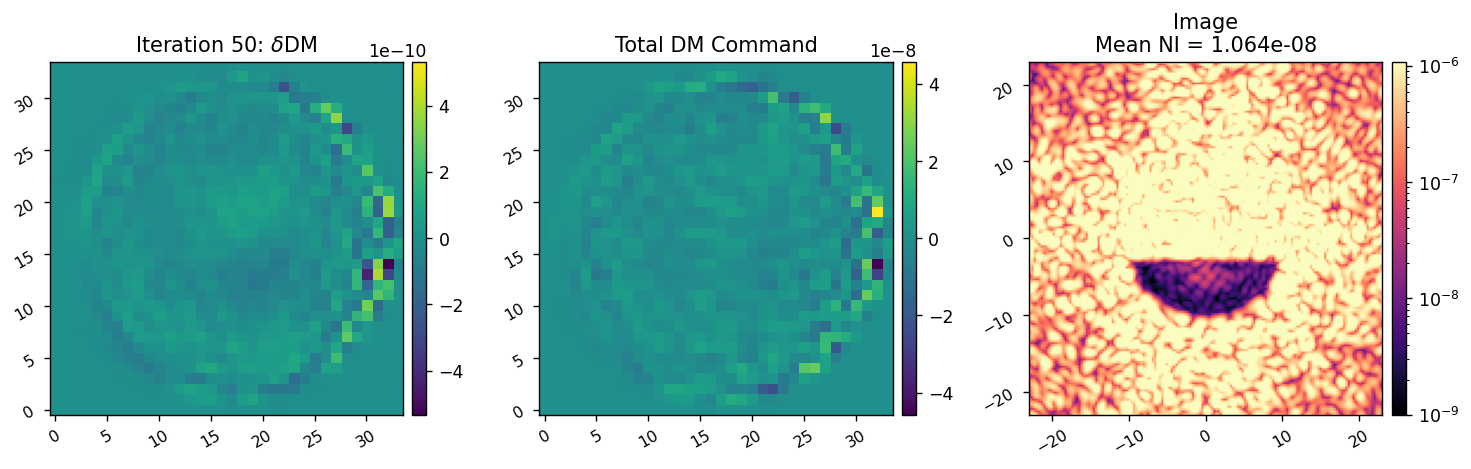

In [191]:
reload(scoobm)
reload(aefc)

I.NSCICAM = 50

bfgs_tol = 1e-2
bfgs_tol = 1e-3
# bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':True,
    'maxiter':25,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

pwp_params = {
    'control_mask':control_mask, 
    'probes':fourier_probes,
    'probe_amp':2.5e-9,
    'probe_amp':1.75e-9,
    'probe_amp':1e-9,
    'probe_amp':0.75e-9,
    'probe_amp':0.5e-9,
    'probe_amp':0.3e-9,
    # 'probe_amp':0.2e-9,
    'wavelength':I.wavelength_c,
    'reg_cond':1e-2,
    # 'reg_cond':1e-3,
    # 'reg_cond':1e-4,
    'Ndms':1,
    # 'plot':True,
    'plot_est':True, 
}

data = aefc.run(
    I, 
    M, 
    scoobm.val_and_grad, 
    control_mask, 
    data,
    pwp_params=pwp_params,
    # Nitr=2, reg_cond=1e-1,
    Nitr=3, reg_cond=1e-2,
    # Nitr=2, reg_cond=1e-3,
    # Nitr=2, reg_cond=1e-4,
    # Nitr=2, reg_cond=1e-5,
    # Nitr=2, reg_cond=1e-6,
    # Nitr=2, reg_cond=1e-7,
    # Nitr=2, reg_cond=1e-8,
    # Nitr=2, reg_cond=1e-9,
    # Nitr=2, reg_cond=1e-10,
    bfgs_tol=bfgs_tol,
    bfgs_opts=bfgs_opts,
    gain=1,
    vmin=1e-9, 
)

In [201]:
utils.save_pickle(f'data/{today}_scoob_aefc_run.pkl', data)

Saved data to:  data/20250115_scoob_aefc_run.pkl


# Adjust attenuation for better SNR.

In [170]:
I.set_fib_atten(0, client)

Set the fiber attenuation to 0.0


1.2796309814328835e-08


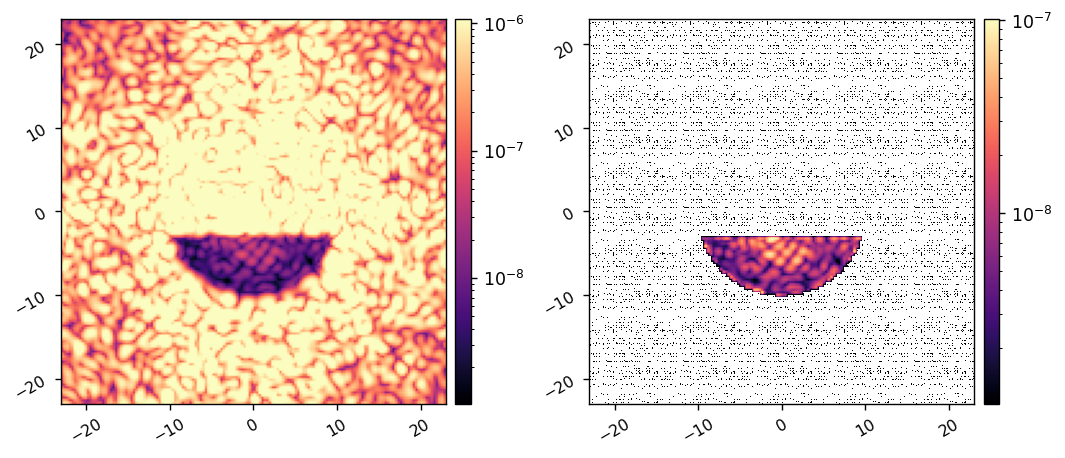

In [184]:
I.NSCICAM = 50
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[control_mask]))
imshow2(coro_im, control_mask * coro_im,
        lognorm=True, pxscl=I.psf_pixelscale_lamDc)

In [202]:
I.zero_dm()
I.set_zwo_exp_time(0.001, client0)
I.set_fib_atten(5, client)

Set the ZWO exposure time to 1.00e-03s
Set the fiber attenuation to 5.0


In [127]:
I.set_zwo_exp_time(0.001, client0)

Set the ZWO exposure time to 1.00e-03s


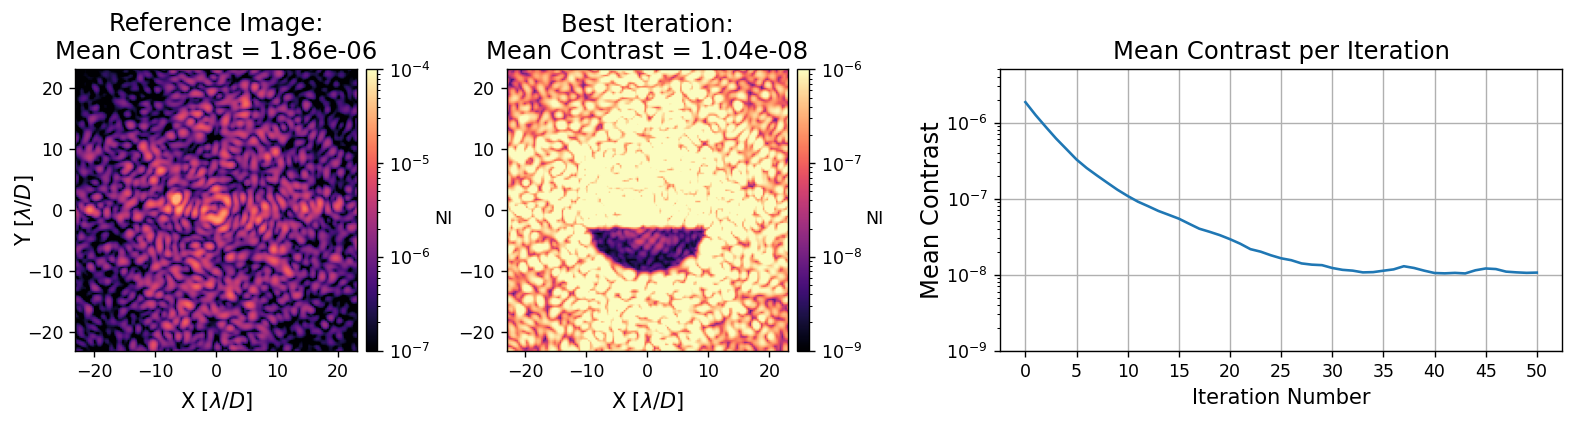

In [200]:
from adefc_vortex import imshows
reload(imshows)

imshows.plot_data_with_ref(
    data, 
    im1vmax=1e-4, im1vmin=1e-7, 
    im2vmax=1e-6, im2vmin=1e-9, 
    vmax=5e-6, vmin=1e-9, 
    xticks=np.arange(0, 50+1, 5),
    fname='../figs/scoob_mono_result.pdf',
)

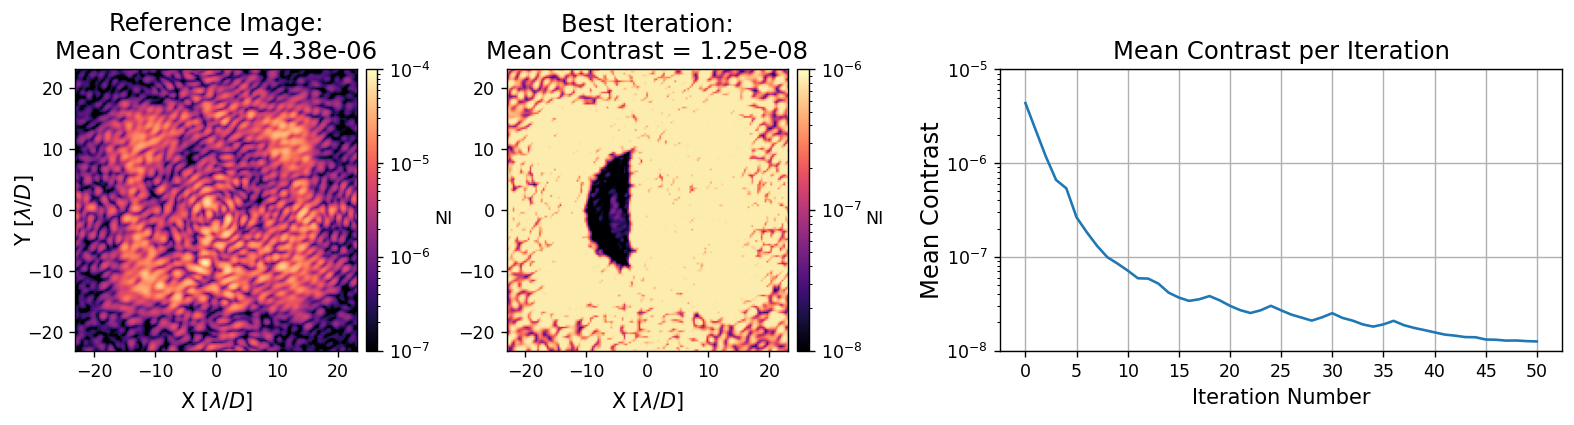

In [111]:
from adefc_vortex import imshows
reload(imshows)

imshows.plot_data_with_ref(
    data, 
    im1vmax=1e-4, im1vmin=1e-7, 
    im2vmax=1e-6, im2vmin=1e-8, 
    vmax=1e-5, vmin=1e-8, 
    xticks=np.arange(0, 50+1, 5),
    fname='../figs/scoob_mono_result.pdf',
)

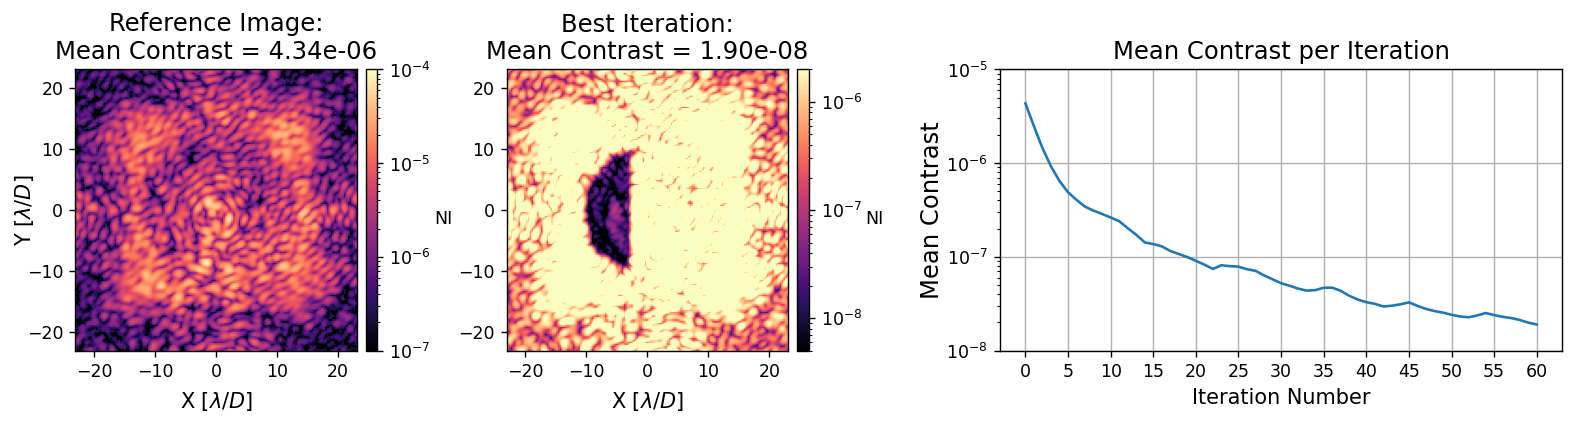

In [109]:
data = utils.load_pickle(f'data/{20241217}_scoob_aefc_run.pkl')

imshows.plot_data_with_ref(
    data, 
    im1vmax=1e-4, im1vmin=1e-7, 
    im2vmax=2e-6, im2vmin=5e-9, 
    vmax=1e-5, vmin=1e-8, 
    xticks=np.arange(0, 61, 5),
    fname='../figs/scoob_mono_result.pdf',
)

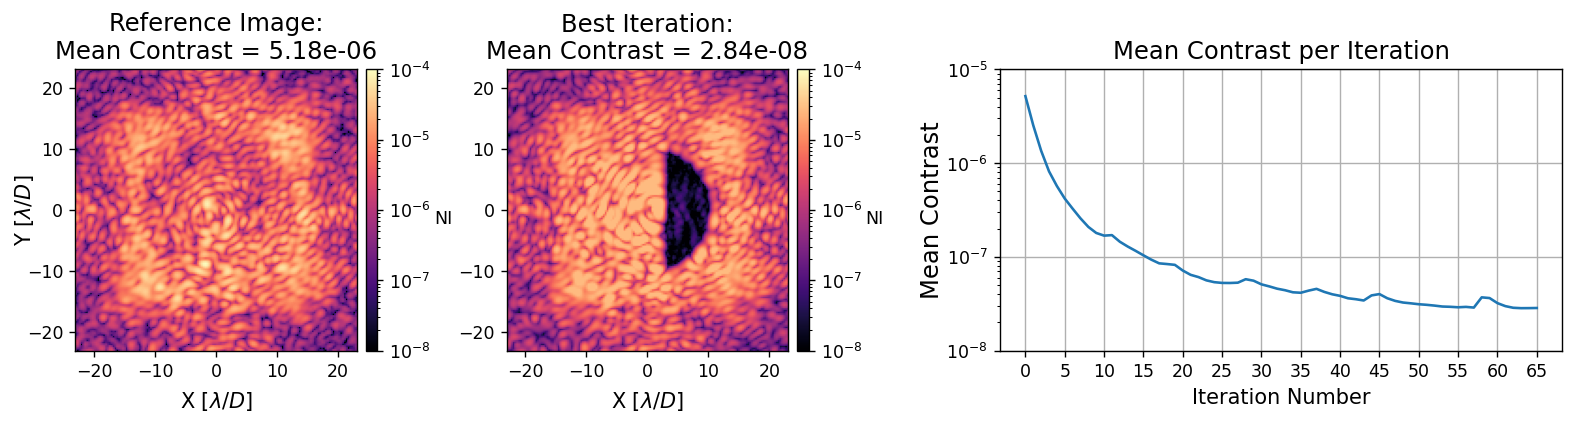

In [184]:
from adefc_vortex import imshows
reload(imshows)

imshows.plot_data_with_ref(
    data, 
    im1vmax=1e-4, im1vmin=1e-8, 
    im2vmax=1e-4, im2vmin=1e-8, 
    vmax=1e-5, vmin=1e-8, 
    xticks=np.arange(0, 66, 5),
)

In [10]:
M = scoobm.MODEL()
iwa = 3
owa = 10
rotation = 0
control_mask = utils.create_annular_focal_plane_mask(M.npsf, M.psf_pixelscale_lamDc, iwa, owa, edge=iwa, rotation=rotation)


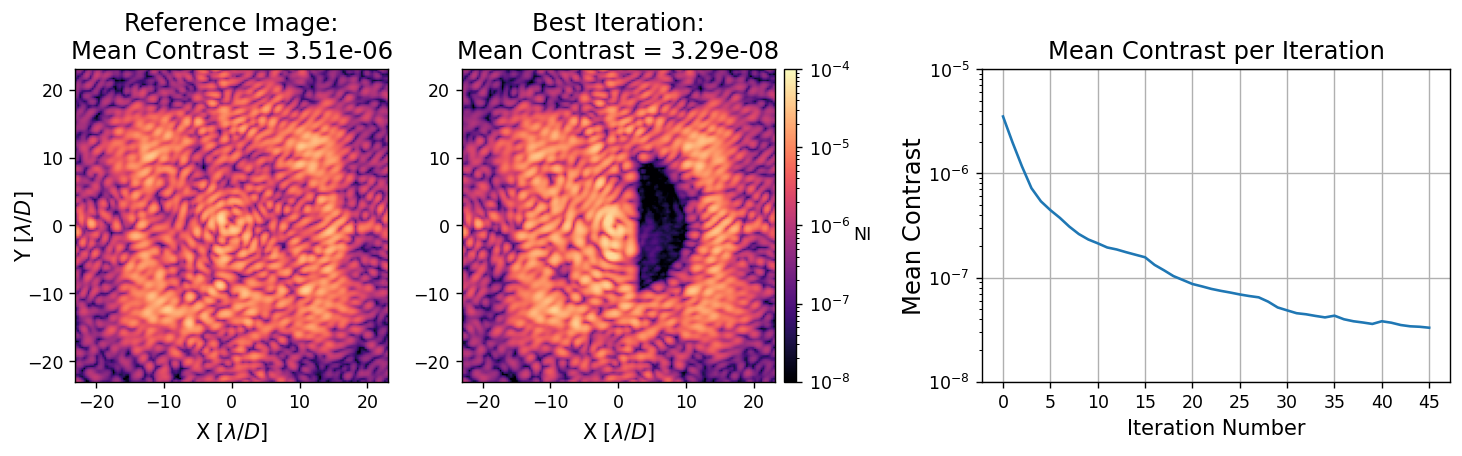

In [25]:
from adefc_vortex import imshows
reload(imshows)

date = 20241029
ref_im = utils.load_fits(f'data/{date}_ref_coro_im.fits')
ims = utils.load_fits(f'data/{date}_adefc_ims.fits')

data = {
    'images':xp.concatenate([xp.array([ref_im]), ims]),
    'control_mask': control_mask,
    'pixelscale':M.psf_pixelscale_lamDc,
}

imshows.plot_data(
    data, 
    imvmax=1e-4, imvmin=1e-8, 
    vmax=1e-5, vmin=1e-8, 
    xticks=np.arange(0, 46, 5),
)
